# Second attempt at actor-critic - randomized environments

In this second attempt, I will use the same actor-critic model/algorithm, but now instead of having a single fixed graph to train on, I will generate a bunch of random ones that will hopefully give the agent a bit more opportunity to generalize to unseen problems.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/ecotner/neural_tsp/notebooks/training

/home/ecotner/neural_tsp/notebooks/training


In [3]:
import time
import random

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

from neuraltsp.environments import RandomTSPEnv
from neuraltsp.models.actor_critic_02 import Actor, Critic

In [4]:
# initialize GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


I'm going to use a randomly-generated set of TSP problems to solve, where each one will have a random number of stops between 10 and 20.

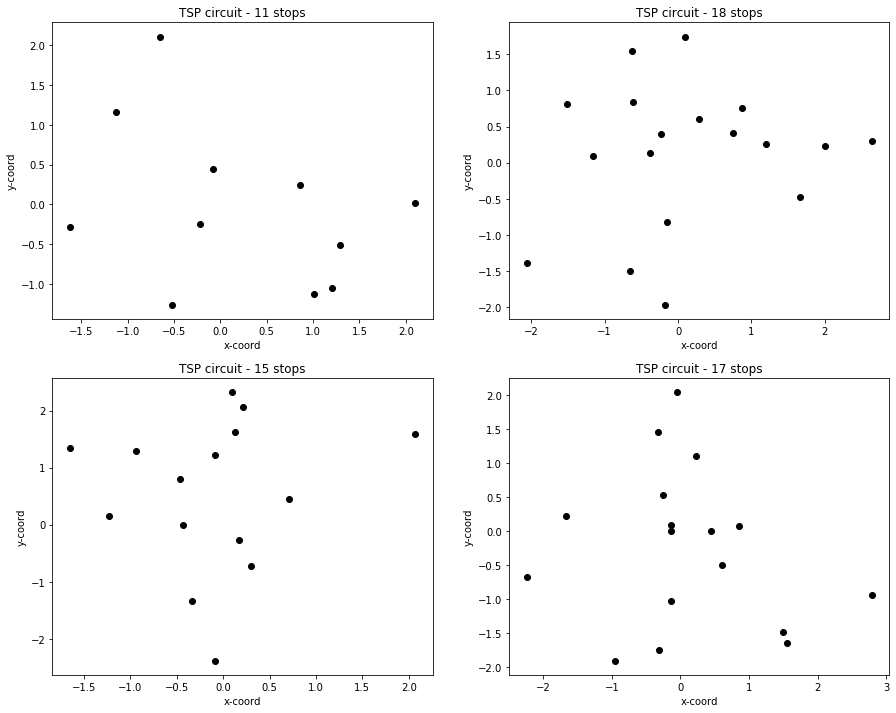

In [5]:
env = RandomTSPEnv(n_locs=list(range(10, 21)), device=device)
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))
for ax in axes.flatten():
    plt.sca(ax)
    env.reset()
    env.render()
    plt.title(f"TSP circuit - {env.locs.shape[0]} stops")
plt.show()

In [10]:
# Initialize policy/value network
actor = Actor()
critic = Critic()
critic.output_bias.data = torch.tensor(-20.0, dtype=torch.float)
actor.to(device);
critic.to(device);

In [11]:
# Initialize optimizer
lr = 1e-5
val_optimizer = optim.SGD(params=critic.parameters(), lr=lr, momentum=0.99)
actor_optimizer = optim.SGD(params=actor.parameters(), lr=lr, momentum=0.99)

In [12]:
# Log training loss, reward, etc.
with open("train.log", "w+") as fp:
    fp.write("loss,reward,q_value")

In order to encourage exploration, a random permuation of the locations is chosen with probability equal to the fraction of time left in the training loop. We run this for 20 minutes and save the critic loss, reward, and Q-value at each step:

In [32]:
def state_to_tensors(s):
    N = s.locs.shape[0]
    A = 1/(s.dmatrix + torch.eye(N, dtype=float, device=device))
    A = A / torch.max(torch.abs(A))
    V = s.locs.reshape(1, -1, 2)
    A = A.type(torch.float).to(device)
    V = V.type(torch.float).to(device)
    return N, A, V

In [22]:
max_time = 30*60
tic = time.time()
episode = 0
with open("train.log", "a") as fp, tqdm.tqdm(total=max_time) as pbar:
    while time.time() - tic < max_time:
        # Reset environment and get state -> convert to A, V
        s = env.reset()
        N, A, V = state_to_tensors(s)
        # Take action and update state
        action = actor(A, V)
        # Add random noise occasionally
        # eps = (time.time() - tic)/max_time
        # eps = (1 - 0.025)*np.exp(-eps/0.25) + 0.025
        if random.random() < 0.025:
            action = action[:,torch.randperm(N)]
        Q = critic(A, V, action)
        # Turn the ordered vector into a sequence of stops
        action = action.squeeze().argsort()
        s, r, _, _ = env.step(action, kind="re-order")
        # Update actor
        actor_optimizer.zero_grad()
        loss = -Q
        loss.backward(retain_graph=True)
        actor_optimizer.step()
        q_val = -loss.data.cpu().numpy()
        # Update critic
        val_optimizer.zero_grad()
        loss = torch.pow(r - Q, 2)
        loss.backward()
        val_optimizer.step()
        loss_val = loss.data.cpu().numpy()
        fp.write(f"\n{loss_val},{r},{q_val}")
        if episode % 100 == 99:
            pbar.n = int(time.time() - tic)
            pbar.set_description(
                f"Episode {episode+1}; "
                f"loss: {loss_val:.3f}; Q-value: {q_val:.3f}; "
                f"reward: {r:.3f}; "
                f"eps: {eps:.3f}"
            )
        episode += 1

Episode 339700; loss: 0.000; Q-value: -16.509; reward: -16.491; eps: 0.043: 100%|█████████▉| 1799/1800 [30:00<00:01,  1.00s/it]


In [44]:
torch.save(actor, "02_actor.torch")
torch.save(critic, "02_critic.torch")

Ok, so it does seem like the agent is learning _something_... the routes are not zigzagging randomly across the map anymore. They are not terribly efficient either, but you can see there is some clustering of nearby neighbors starting to happen.

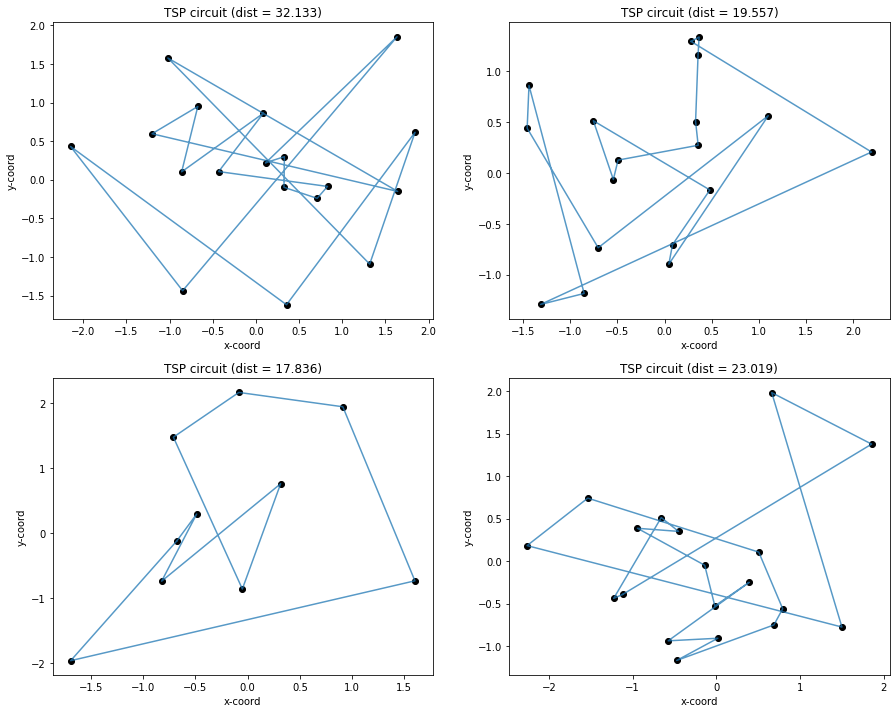

In [35]:
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))
for ax in axes.flatten():
    plt.sca(ax)
    s = env.reset()
    N, A, V = state_to_tensors(s)
    # Take action and update state
    action = actor(A, V)
    Q = critic(A, V, action)
    # Turn the ordered vector into a sequence of stops
    action = action.squeeze().argsort()
    s, r, _, _ = env.step(action, kind="re-order")
    env.render()
plt.show()

In [36]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [37]:
train_df = pd.read_csv("train.log")
size = len(train_df)
print(f"{size} rows/episodes")
train_df.tail()

598840 rows/episodes


,loss,reward,q_value
598835,7.586553,-26.132721,-23.378351
598836,49.485184,-16.463978,-23.498549
598837,19.550854,-31.285685,-26.864050
598838,9.600627,-18.956654,-22.055141
598839,0.296005,-19.386248,-18.842184


The critic seems to be doing a really good job; the Q-value tracks the reward pretty well.

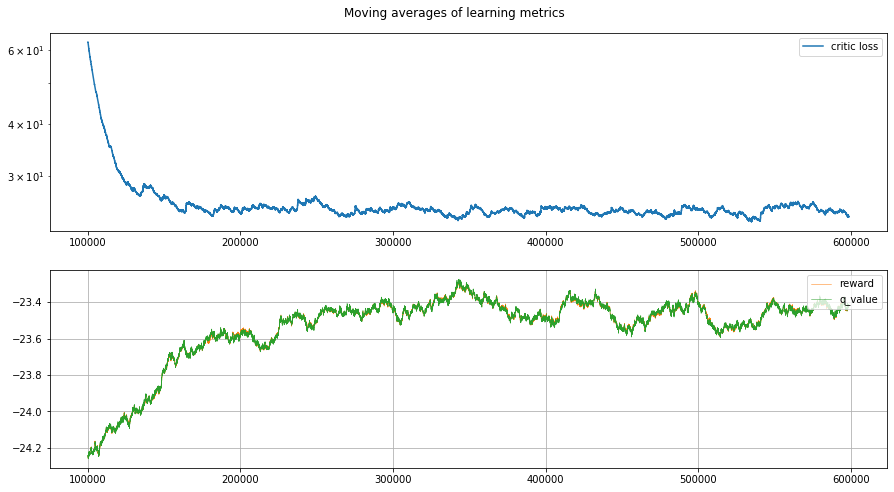

In [40]:
ma = train_df.ewm(span=len(train_df)/30).mean()
fig, axes = plt.subplots(nrows=2, figsize=(15,8))
skip = 100000

axes[0].plot(ma.iloc[skip:]['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")

axes[1].plot(ma.iloc[skip:]['reward'], label='reward', color="C1", linewidth=0.5)
axes[1].plot(ma.iloc[skip:]['q_value'], label='q_value', color="C2", linewidth=0.5)
axes[1].grid()
axes[1].legend(loc="upper right")

fig.suptitle("Moving averages of learning metrics", x=0.5, y=0.925)
plt.show()

It seems that now, the critic is actually learning something about the value of the states!

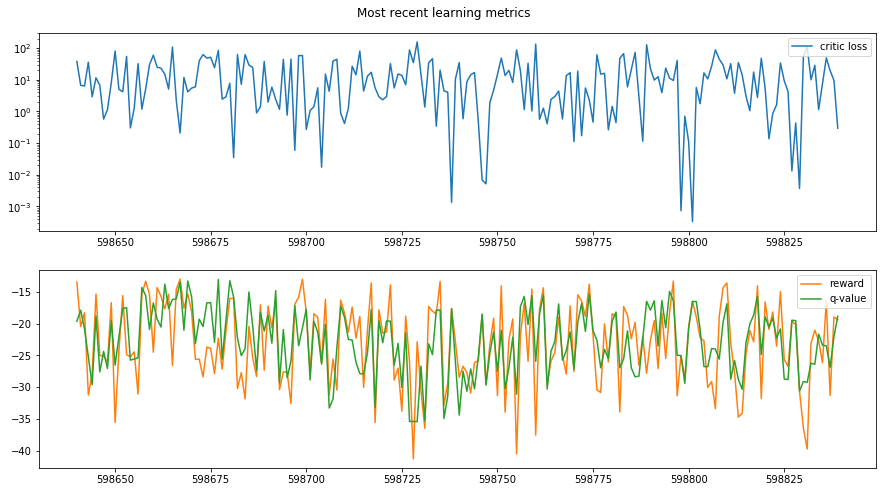

In [41]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
window = 200
df = train_df.iloc[-window:]

axes[0].plot(df['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")
axes[1].plot(df['reward'], label='reward', color="C1")
axes[1].plot(df['q_value'], label='q-value', color="C2")
axes[1].legend(loc="upper right")

fig.suptitle("Most recent learning metrics", x=0.5, y=0.925)
plt.show()

There is even a statistically-significant correlation between the predicted Q-values and the rewards!

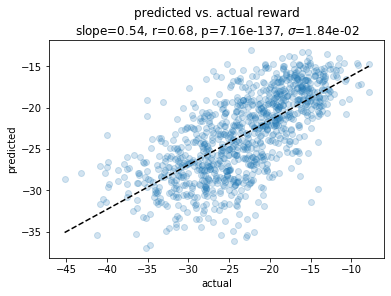

In [42]:
window = 1000
x = train_df.iloc[-window:]['reward'].values
y = train_df.iloc[-window:]['q_value'].values
plt.scatter(x, y, alpha=1/5)
m, b, r, p, s = stats.linregress(x, y)
x = np.linspace(x.min(), x.max(), 3)
y = m*x + b
plt.plot(x, y, linestyle="--", color='black')
plt.title(f"predicted vs. actual reward\nslope={m:.2f}, r={r:.2f}, p={p:.2e}, $\sigma$={s:.2e}")
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

However, it seems that the policy does not improve appreciably, it kind of gets stuck at the "group stops into clusters" stage, but doesn't learn anything beyond that. And if we look at the structure of the actor network, it makes sense:

In [43]:
actor

Actor(
  (conv1): NodeToNode()
  (conv2): NodeToNode()
  (conv3): NodeToNode()
)

There are only three convolutional layers, so it is probably difficult to do multi-stop correlations. In addition, the convolutions are only over nodes of the graph, not edges... the message-passing mechanism is fixed by the adjacency matrix $A$. I like to think I chose a fairly good $A$ (basically the element-wise inverse of the distance matrix $D$), but there's no guarantee that it actually makes sense. The model should be able to determine its own edge features to influence message-passing, and $D$ and $A$ should just be inputs. I will try that in the next model.